## Work
1. 請改變 reduce_lr 的 patience 和 factor 並比較不同設定下，對訓練/驗證集的影響
2. 請將 optimizer 換成 Adam、RMSprop 搭配 reduce_lr 並比較訓練結果

In [1]:
import os
import keras

# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = ""

Using TensorFlow backend.


In [2]:
train, test = keras.datasets.cifar10.load_data()

In [3]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [4]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [5]:
from keras.layers import BatchNormalization

"""
建立神經網路，並加入 BN layer
"""
def build_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128]):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(input_layer)
            x = BatchNormalization()(x)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(x)
            x = BatchNormalization()(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [6]:
LEARNING_RATE = 1e-3
EPOCHS = 25 # IF you feel too run to finish, try to make it smaller
BATCH_SIZE = 1024 

In [7]:
# 載入 Callbacks
from keras.callbacks import ReduceLROnPlateau

optimizer_set = [keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=0.95),
                 keras.optimizers.Adam(lr=LEARNING_RATE),
                 keras.optimizers.RMSprop(lr=LEARNING_RATE)]

"""Code Here
建立實驗的比較組合
"""
reduce_lr_factor = [0.5,0.8]
redice_lr_patient = [5,8]

Instructions for updating:
Colocations handled automatically by placer.


In [8]:
import itertools
results = {}
for i, (optim, reduce_factor, reduce_patient) in enumerate(itertools.product(optimizer_set, reduce_lr_factor, redice_lr_patient)):
    print("Numbers of exp: %i, reduce_factor: %.2f, reduce_patient: %i" % (i, reduce_factor, reduce_patient))
    model = build_mlp(input_shape=x_train.shape[1:])
    model.summary()
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optim)
    
    """Code Here
    設定 reduce learning rate 的 callback function
    """
    reduce_lr = ReduceLROnPlateau(factor=reduce_factor, 
                              min_lr=1e-12, 
                              monitor='val_loss', 
                              patience=reduce_patient, 
                              verbose=1)
    
    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=BATCH_SIZE, 
              validation_data=(x_test, y_test), 
              shuffle=True,
              callbacks=[reduce_lr]
             )

    # Collect results
    exp_name_tag = ("exp-%s" % (i))
    results[exp_name_tag] = {'train-loss': model.history.history["loss"],
                             'valid-loss': model.history.history["val_loss"],
                             'train-acc': model.history.history["acc"],
                             'valid-acc': model.history.history["val_acc"]}

Numbers of exp: 0, reduce_factor: 0.50, reduce_patient: 5
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_1 (Batch (None, 512)               2048      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
batch_normalization_2 (Batch (None, 256)               1024      
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
batch_normalizatio

Epoch 11/25
50000/50000 [==============================] - 8s 163us/step - loss: 1.4009 - acc: 0.5104 - val_loss: 1.5636 - val_acc: 0.4514
Epoch 12/25
50000/50000 [==============================] - 8s 153us/step - loss: 1.3790 - acc: 0.5207 - val_loss: 1.5521 - val_acc: 0.4591
Epoch 13/25
50000/50000 [==============================] - 8s 152us/step - loss: 1.3595 - acc: 0.5289 - val_loss: 1.5455 - val_acc: 0.4586
Epoch 14/25
50000/50000 [==============================] - 9s 177us/step - loss: 1.3397 - acc: 0.5352 - val_loss: 1.5331 - val_acc: 0.4631
Epoch 15/25
50000/50000 [==============================] - 8s 169us/step - loss: 1.3212 - acc: 0.5427 - val_loss: 1.5218 - val_acc: 0.4690
Epoch 16/25
50000/50000 [==============================] - 8s 153us/step - loss: 1.3035 - acc: 0.5493 - val_loss: 1.5233 - val_acc: 0.4642
Epoch 17/25
50000/50000 [==============================] - 7s 148us/step - loss: 1.2876 - acc: 0.5574 - val_loss: 1.5128 - val_acc: 0.4738
Epoch 18/25
50000/50000 [==

Train on 50000 samples, validate on 10000 samples
Epoch 1/25
50000/50000 [==============================] - 38s 757us/step - loss: 2.3888 - acc: 0.2304 - val_loss: 2.2433 - val_acc: 0.2829
Epoch 2/25
50000/50000 [==============================] - 7s 148us/step - loss: 1.8670 - acc: 0.3593 - val_loss: 1.9018 - val_acc: 0.3555
Epoch 3/25
50000/50000 [==============================] - 8s 159us/step - loss: 1.7275 - acc: 0.4022 - val_loss: 1.7762 - val_acc: 0.3896
Epoch 4/25
50000/50000 [==============================] - 8s 152us/step - loss: 1.6523 - acc: 0.4258 - val_loss: 1.7108 - val_acc: 0.3998
Epoch 5/25
50000/50000 [==============================] - 8s 155us/step - loss: 1.5986 - acc: 0.4452 - val_loss: 1.6757 - val_acc: 0.4139
Epoch 6/25
50000/50000 [==============================] - 8s 153us/step - loss: 1.5557 - acc: 0.4610 - val_loss: 1.6450 - val_acc: 0.4247
Epoch 7/25
50000/50000 [==============================] - 8s 166us/step - loss: 1.5197 - acc: 0.4723 - val_loss: 1.6224 -

50000/50000 [==============================] - 8s 167us/step - loss: 0.4798 - acc: 0.8535 - val_loss: 1.5930 - val_acc: 0.5115
Epoch 23/25
50000/50000 [==============================] - 8s 164us/step - loss: 0.4567 - acc: 0.8638 - val_loss: 1.6428 - val_acc: 0.5094
Epoch 24/25
50000/50000 [==============================] - 8s 167us/step - loss: 0.4354 - acc: 0.8737 - val_loss: 1.6211 - val_acc: 0.5025

Epoch 00024: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.
Epoch 25/25
50000/50000 [==============================] - 8s 167us/step - loss: 0.3867 - acc: 0.8956 - val_loss: 1.5930 - val_acc: 0.5240
Numbers of exp: 5, reduce_factor: 0.50, reduce_patient: 8
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)             

50000/50000 [==============================] - 8s 158us/step - loss: 1.1757 - acc: 0.5955 - val_loss: 1.4928 - val_acc: 0.4737
Epoch 9/25
50000/50000 [==============================] - 8s 160us/step - loss: 1.1402 - acc: 0.6087 - val_loss: 1.4870 - val_acc: 0.4775
Epoch 10/25
50000/50000 [==============================] - 8s 158us/step - loss: 1.1081 - acc: 0.6192 - val_loss: 1.4485 - val_acc: 0.4920
Epoch 11/25
50000/50000 [==============================] - 8s 160us/step - loss: 1.0779 - acc: 0.6321 - val_loss: 1.4512 - val_acc: 0.4900
Epoch 12/25
50000/50000 [==============================] - 8s 159us/step - loss: 1.0498 - acc: 0.6430 - val_loss: 1.4239 - val_acc: 0.4992
Epoch 13/25
50000/50000 [==============================] - 8s 159us/step - loss: 1.0230 - acc: 0.6540 - val_loss: 1.4662 - val_acc: 0.4786
Epoch 14/25
50000/50000 [==============================] - 8s 158us/step - loss: 0.9975 - acc: 0.6641 - val_loss: 1.4264 - val_acc: 0.4991
Epoch 15/25
50000/50000 [===============

Train on 50000 samples, validate on 10000 samples
Epoch 1/25
50000/50000 [==============================] - 38s 768us/step - loss: 1.8306 - acc: 0.3721 - val_loss: 2.2398 - val_acc: 0.2952
Epoch 2/25
50000/50000 [==============================] - 7s 139us/step - loss: 1.5472 - acc: 0.4542 - val_loss: 2.0253 - val_acc: 0.2925
Epoch 3/25
50000/50000 [==============================] - 8s 153us/step - loss: 1.4445 - acc: 0.4885 - val_loss: 2.2567 - val_acc: 0.2992
Epoch 4/25
50000/50000 [==============================] - 8s 154us/step - loss: 1.3648 - acc: 0.5180 - val_loss: 1.8469 - val_acc: 0.3596
Epoch 5/25
50000/50000 [==============================] - 8s 157us/step - loss: 1.3055 - acc: 0.5376 - val_loss: 1.7671 - val_acc: 0.3787
Epoch 6/25
50000/50000 [==============================] - 8s 155us/step - loss: 1.2562 - acc: 0.5566 - val_loss: 1.9354 - val_acc: 0.3351
Epoch 7/25
50000/50000 [==============================] - 8s 157us/step - loss: 1.2129 - acc: 0.5714 - val_loss: 2.0377 -

50000/50000 [==============================] - 8s 155us/step - loss: 0.6411 - acc: 0.7992 - val_loss: 1.5387 - val_acc: 0.4937
Epoch 23/25
50000/50000 [==============================] - 8s 157us/step - loss: 0.6189 - acc: 0.8068 - val_loss: 1.5168 - val_acc: 0.5003
Epoch 24/25
50000/50000 [==============================] - 8s 155us/step - loss: 0.5984 - acc: 0.8169 - val_loss: 1.5758 - val_acc: 0.4852
Epoch 25/25
50000/50000 [==============================] - 8s 158us/step - loss: 0.5809 - acc: 0.8225 - val_loss: 1.6340 - val_acc: 0.4768
Numbers of exp: 10, reduce_factor: 0.80, reduce_patient: 5
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_11 (InputLayer)        (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
b

50000/50000 [==============================] - 8s 169us/step - loss: 1.2583 - acc: 0.5630 - val_loss: 1.6196 - val_acc: 0.4393
Epoch 9/25
50000/50000 [==============================] - 8s 163us/step - loss: 1.2164 - acc: 0.5813 - val_loss: 1.5851 - val_acc: 0.4452
Epoch 10/25
50000/50000 [==============================] - 8s 165us/step - loss: 1.1818 - acc: 0.5929 - val_loss: 1.5076 - val_acc: 0.4694
Epoch 11/25
50000/50000 [==============================] - 8s 163us/step - loss: 1.1494 - acc: 0.6062 - val_loss: 1.6253 - val_acc: 0.4393
Epoch 12/25
50000/50000 [==============================] - 8s 164us/step - loss: 1.1168 - acc: 0.6182 - val_loss: 1.6724 - val_acc: 0.4191
Epoch 13/25
50000/50000 [==============================] - 8s 164us/step - loss: 1.0874 - acc: 0.6303 - val_loss: 1.5006 - val_acc: 0.4745
Epoch 14/25
50000/50000 [==============================] - 8s 163us/step - loss: 1.0563 - acc: 0.6411 - val_loss: 1.5080 - val_acc: 0.4744
Epoch 15/25
50000/50000 [===============

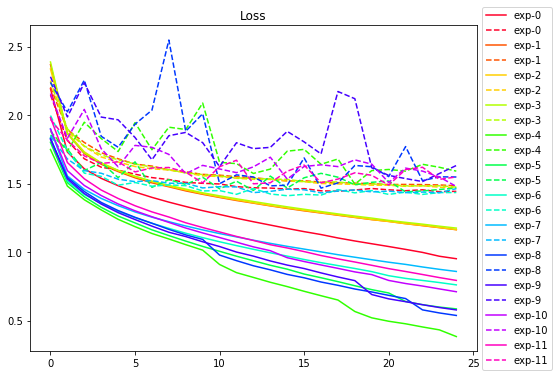

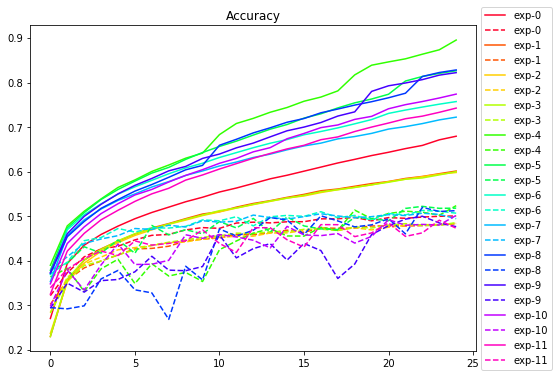

In [9]:
import matplotlib.pyplot as plt
import matplotlib.cm as mplcm
import matplotlib.colors as colors
%matplotlib inline
NUM_COLORS = len(results.keys())

cm = plt.get_cmap('gist_rainbow')
cNorm  = colors.Normalize(vmin=0, vmax=NUM_COLORS-1)
scalarMap = mplcm.ScalarMappable(norm=cNorm, cmap=cm)
color_bar = [scalarMap.to_rgba(i) for i in range(NUM_COLORS)]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()